In [64]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
sc.settings.set_figure_params(dpi=60, facecolor='white')
os.chdir('/share2/pub/zhangyr/zhangyr/single-RNA/cellTypeAnno')
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [4]:
sc.settings.verbosity = 3  
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

2022-11-30 14:16:48.260559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


scanpy==1.9.1 anndata==0.8.0 umap==0.5.2 numpy==1.22.4 scipy==1.7.1 pandas==1.1.4 scikit-learn==0.22 statsmodels==0.12.2 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.4


## 数据：
* 链接：https://www.dropbox.com/s/i8mwmyymchx8mn8/sce.all_classified.technologies.RData?dl=0
* 参考：Mereu E, Lafzi A, Moutinho C, Ziegenhain C et al. Benchmarking single-cell RNA-sequencing protocols for cell atlas projects. Nat Biotechnol 2020 Jun;38(6):747-755. PMID: 32518403
* 处理数据，共包含13种测序技术的单细胞矩阵，提取Chromium 10X 和 Smart-seq
* 10X作为参考数据集，Smart-seq2作为测试数据集

In [78]:
#reference = sc.read_h5ad('./data/Chromium10X_V3.h5ad')
#target = sc.read_h5ad('./data/Smart_seq_V2.h5ad')

reference = sc.read_csv('./data/Chromium10X_V3.csv')
reference = reference.T
target = sc.read_csv('./data/Smart_seq_V2.csv')
target = target.T
reference_meta = pd.read_csv('./data/meta_Chromium10X_V3.csv',index_col=0)
reference.obs = reference_meta
reference.obsm['X_umap'] = reference_meta[['UMAP_1','UMAP_2']].values

In [55]:
reference

AnnData object with n_obs × n_vars = 1185 × 23381
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellType'
    uns: 'cellType_colors'
    obsm: 'X_umap'

In [56]:
target

AnnData object with n_obs × n_vars = 690 × 23381
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellType'
    uns: 'cellType_colors'
    obsm: 'X_umap'

# SCANVI
* tutorial参考：https://scarches.readthedocs.io/en/latest/scanvi_surgery_pipeline.html
* 安装：pip install -U scarches

In [6]:
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

Global seed set to 0
/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [18]:
genes = list(set(reference.var_names) & set(target.var_names))

reference = reference[:,genes]
target = target[:, genes]

In [19]:
reference = reference.copy()
target = target.copy()

In [67]:
sca.models.SCVI.setup_anndata(reference, labels_key='cellType')
vae = sca.models.SCVI(
    reference,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="none",
    use_batch_norm="none",
)

In [69]:
vae.train(max_epochs=30)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 30/30: 100%|██████████| 30/30 [02:56<00:00,  5.99s/it, loss=6.89e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [02:56<00:00,  5.88s/it, loss=6.89e+03, v_num=1]


In [70]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [71]:
scanvae.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [01:04<00:00,  6.43s/it, loss=6.91e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:04<00:00,  6.47s/it, loss=6.91e+03, v_num=1]


In [72]:
ref_path = './results/models/SCANVI'
scanvae.save(ref_path, overwrite=True)

### 预测

In [77]:
target.obs = target.obs[,[['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellType', 'cellTypiest_pred']]]

AnnData object with n_obs × n_vars = 690 × 23381
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellType', 'cellTypiest_pred', '_scvi_batch'
    uns: 'cellType_colors', 'cellTypiest_pred_colors'
    obsm: 'X_umap'

In [79]:
model = sca.models.SCANVI.load_query_data(
    target,
    ref_path,
    freeze_dropout = True,
)

INFO     File ./results/models/SCANVI/model.pt already downloaded                                                  


In [80]:
model.train(
    max_epochs=30,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 30 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 30/30: 100%|██████████| 30/30 [01:06<00:00,  2.19s/it, loss=7.3e+04, v_num=1] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [01:06<00:00,  2.21s/it, loss=7.3e+04, v_num=1]


In [81]:
target_path = './results/models/SCANVI/models/SCANVI_pred'
model.save(target_path, overwrite=True)

In [83]:
model = sca.models.SCANVI.load(target_path,target)

INFO     File ./results/models/SCANVI/models/SCANVI_pred/model.pt already downloaded                               


In [84]:
scANVI_pred = pd.DataFrame(list(model.predict()), index = target.obs_names)
scANVI_pred.head()

,0
SMARTseqFINAL_allLanes_AACATCCGAAGAGAGG,NK cells
SMARTseqFINAL_allLanes_AACATCCGCAGTATCG,NK cells
SMARTseqFINAL_allLanes_AACATCCGCCTCCTAA,B cells
SMARTseqFINAL_allLanes_AACATCCGCGAATCTG,NK cells
SMARTseqFINAL_allLanes_AACATCCGCGCCTATA,NK cells


In [88]:
target_meta = pd.read_csv('./data/meta_Smart_seq_V2.csv',index_col=0)
target.obs = target_meta
target.obsm['X_umap'] = target_meta[['UMAP_1','UMAP_2']].values

In [90]:
target.obs['scANVI_pred'] = scANVI_pred.iloc[:,0]

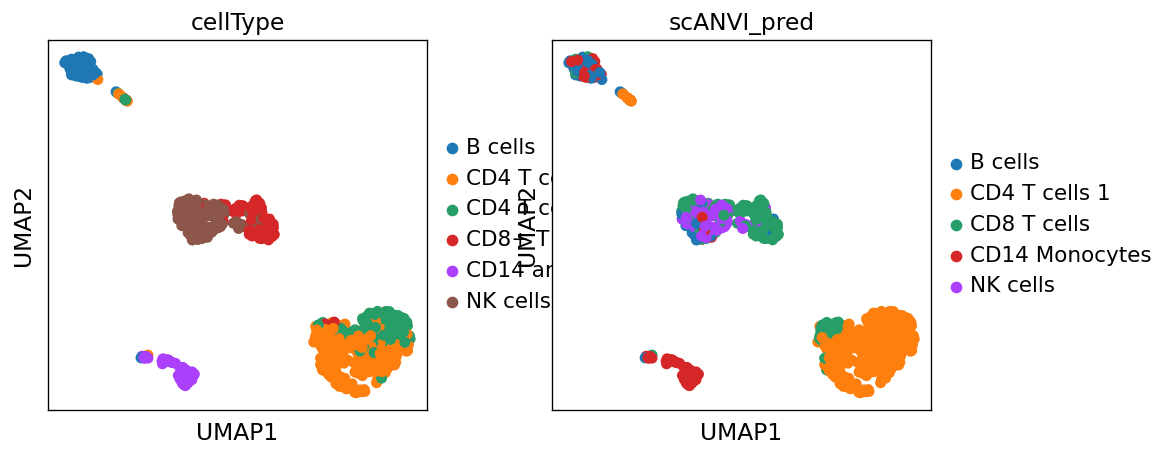

In [91]:
sc.pl.umap(target, color=['cellType','scANVI_pred'])

# cellTypist
* toturial参考：https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb#scrollTo=automotive-traveler
* 安装：pip install celltypist
* 训练好的模型：https://www.celltypist.org/models

In [43]:
from celltypist import models
import celltypist

In [38]:
models.download_models(force_update = True)

In [39]:
models.models_description()

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
3,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...
4,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
5,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
6,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric (health..."
7,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
8,Developing_Human_Brain.pkl,cell types from the first-trimester developing...
9,Developing_Mouse_Brain.pkl,cell types from the embryonic mouse brain betw...


In [40]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [41]:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

### 预测

In [45]:
target.raw = target

In [47]:
sc.pp.normalize_total(target, target_sum=1e4)
sc.pp.log1p(target)

normalizing counts per cell
    finished (0:00:00)


In [48]:
cellTypiest_pred = celltypist.annotate(target, model = 'Immune_All_High.pkl', majority_voting = True)

filtered out 5058 genes that are detected in less than 5 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 49 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


In [59]:
target.obs['cellTypiest_pred'] = cellTypiest_pred.predicted_labels['predicted_labels']

In [57]:
u_d = pd.read_csv('./data/umap_Smart_seq_V2.csv',index_col=0)
target.obsm['X_umap'] = u_d.values

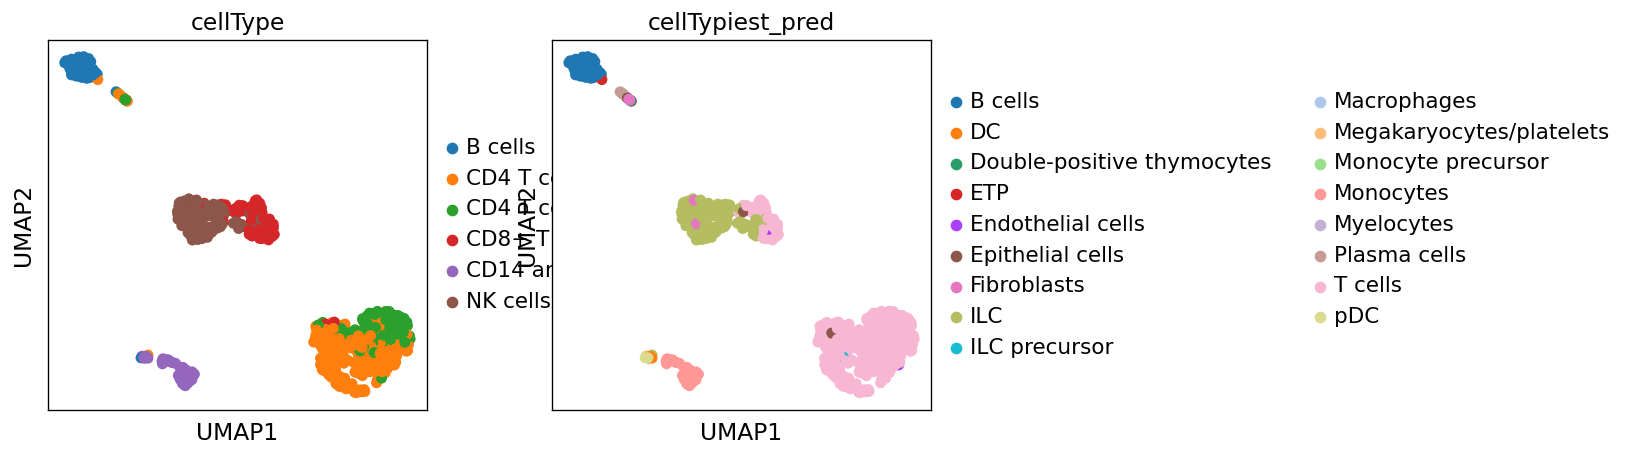

In [65]:
sc.pl.umap(target, color=['cellType','cellTypiest_pred'])